In [2]:
from collections import OrderedDict
import re
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
5,b71b76dc-a9ba-4453-9e21-877371420b34,linear_regression,Transformer,noise_std=0.9_noise_type=poisson_renormalize_y...,-1,-1,5,4,8,_poisson_noise_gaussian_data_experiment
6,bff9a489-6a88-4736-9121-6d492604b98a,linear_regression,Transformer,noise_std=0.9_noise_type=poisson_renormalize_y...,-1,-1,5,4,8,_poisson_noise_vr2_data_experiment
0,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
4,b3ffd953-011e-4961-a8cb-293c52fd7076,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy__
3,77f4f325-1e29-41d3-b2aa-84378107f9e5,linear_regression,Transformer,,-1,-1,5,4,8,poisson_noise_gaussian_data_experiment
7,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
8,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained
1,08f273f7-0f91-46d0-9ebf-35e2a4467653,linear_regression,Transformer,,-1,-1,5,4,8,uniform_noise_gaussian_data_experiment
2,70152b8e-2195-4da8-8329-b43fe3146907,linear_regression,Transformer,,-1,-1,5,4,8,uniform_noise_gaussian_data_experiment_1


In [37]:
task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "08f273f7-0f91-46d0-9ebf-35e2a4467653"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

In [ ]:
# Cell In[26], trước dòng 9

import pprint # Dùng để in dictionary đẹp hơn
# ...
models = relevant_model_names[task]
print("--- Tên mô hình CÓ TRONG relevant_model_names (models) ---")
print(models)
print("\n--- Các khóa (Tên mô hình) THỰC TẾ trong metrics['standard'] ---")
pprint.pprint(metrics["standard"].keys())   

# basic_plot(metrics["standard"], models=models) 
# ...

--- Tên mô hình CÓ TRONG relevant_model_names (models) ---
['gpt2_embd=128_layer=4_head=8', 'Least Squares', 'Ridge Var Adj (alpha=1.0, ar=0.5)', 'Feasible GLS', 'GLS (ar=0.5)']

--- Các khóa (Tên mô hình) THỰC TẾ trong metrics['standard'] ---
dict_keys(['Transformer', 'Least Squares', 'Ridge (alpha=0.1)', 'Ridge (alpha=1.0)', 'Ridge Var Adj (alpha=1.0, ar=0.5)', 'Feasible GLS', 'GLS (ar=0.5)'])


# Plot pre-computed metrics

uniform_noise_gaussian_data_experiment 08f273f7-0f91-46d0-9ebf-35e2a4467653


100%|██████████| 1/1 [00:00<00:00, 940.22it/s]


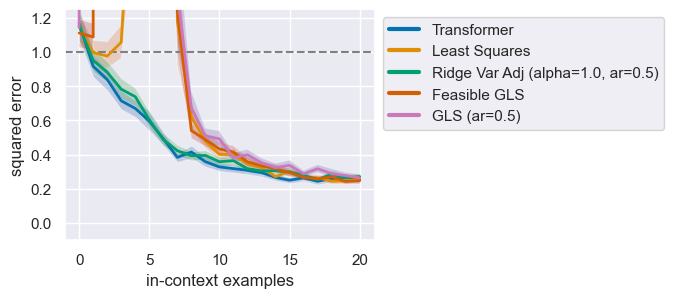

In [38]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

# # Figure 3 and 4
# for model_name in models: 
#     if "gradient_alignment" in metrics["standard"][model_name]:  
#         alignments = metrics["standard"][model_name]["gradient_alignment"]
#         plt.figure(figsize=(6,4))
#         plt.plot(range(len(alignments)), alignments, label=f"{model_name} gradient-w alignment")
#         plt.xlabel("# in-context examples")
#         plt.ylabel("normalized inner product") 
#         plt.legend()
#         plt.show()

In [7]:
# plot any OOD metrics
# print("Available metrics:", list(metrics.keys()))
for name, metric in metrics.items():
    print("Processing:", name)
    print("Metric keys:", list(metric.keys()))
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0
    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    
    # # only plot models that exist in this metric dict
    # models_present = [m for m in models if m in metric]
    # if len(models_present) == 0:
    #     print(f"Skipping {name}: no matching models in metric keys {list(metric.keys())}")
    #     continue
    # fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    # ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)
    plt.show()
# std = metrics.get("standard", {})
# for model_name in models:
#     mres = std.get(model_name, {})
#     if "gradient_alignment" in mres:
#         print("Plotting gradient alignment for", model_name)
#         alignments = mres["gradient_alignment"]
#         plt.figure(figsize=(6, 4))
#         plt.plot(range(len(alignments)), alignments, label=f"{model_name} gradient-w alignment", lw=2)
#         plt.xlabel("# in-context examples")
#         plt.ylabel("normalized inner product")
#         plt.legend()
#         plt.show()

Processing: gradient
Metric keys: ['Transformer', 'Least Squares', 'Ridge (alpha=0.1)', 'Ridge (alpha=1.0)', 'Ridge Var Adj (alpha=1.0, ar=0.5)', 'Feasible GLS', 'GLS (ar=0.5)']


NameError: name 'ax' is not defined

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [6]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [7]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [8]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [9]:
with torch.no_grad():
    pred = model(xs, ys)

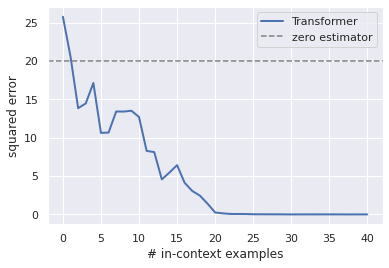

In [10]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [11]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

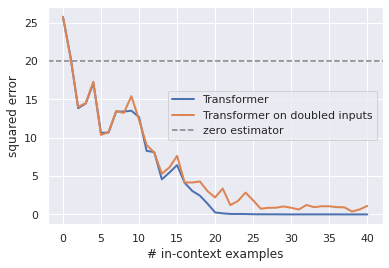

In [12]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.

In [2]:
# Figure 3(a)
import math
import numpy as np
try:
    _ = model
except NameError:
    model, conf = get_model_from_run(run_path)

try:
    _ = task_sampler
except NameError:
    from samplers import get_data_sampler
    from tasks import get_task_sampler
    n_dims = conf.model.n_dims
    batch_size = conf.training.batch_size
    data_sampler = get_data_sampler(conf.training.data, n_dims)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims,
        batch_size,
        **conf.training.task_kwargs
    )

model = model.eval()

def _get_true_w(task):
    return task.w_b[0, :, 0].detach().cpu() if hasattr(task, "w_b") else None

# Helper: project a vector onto the row-space of X (k x d)
def _project_to_row_space(vec, X):
    # X: (k, d); vec: (d,)
    if X.numel() == 0:
        return torch.zeros_like(vec)
    _, _, Vt = torch.linalg.svd(X, full_matrices=False)
    P = Vt.t() @ Vt  # (d x d)
    return (P @ vec)

@torch.no_grad()
def _estimate_range_quantiles(num_samples=4000):
    xs_samp = data_sampler.sample_xs(n_points=num_samples, b_size=1)[0] 
    norms = xs_samp.norm(dim=-1).cpu()
    low = torch.quantile(norms, 0.005).item()
    high = torch.quantile(norms, 0.995).item()
    return low, high


def plot_function_visualizations(num_dirs=3, ks=None, T=15.0, num_steps=200, seed=None):
    torch.manual_seed(seed if seed is not None else torch.seed())

    if ks is None:
        d = conf.model.n_dims
        max_pts = conf.training.curriculum.points.end
        ks = [max(1, d // 2), d, min(2 * d, max_pts)]

    task = task_sampler()  # single-task batch
    w = _get_true_w(task)

    # Precompute norm band
    band_low, band_high = _estimate_range_quantiles()

    fig, axes = plt.subplots(1, num_dirs, figsize=(14, 3.8), sharey=True)
    axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

    for p in range(num_dirs):
        ax = axes[p]

        # Random direction u (unit vector)
        u = torch.randn(n_dims)
        u = u / (u.norm() + 1e-8)

        ts = torch.linspace(-T, T, steps=num_steps)

        # For each k, build a fresh context and sweep the query
        for ki, k in enumerate(ks):
            xs_ctx = data_sampler.sample_xs(n_points=k, b_size=1)  # (1, k, d)
            ys_ctx = task.evaluate(xs_ctx)

            preds = []
            for t in ts:
                xq = (t * u).view(1, 1, -1)
                xs_in = torch.cat([xs_ctx, xq], dim=1)
                ys_in = torch.cat([ys_ctx, torch.zeros_like(ys_ctx[:, :1])], dim=1)
                out = model(xs_in, ys_in, inds=[k])  # predict at query position
                preds.append(out[0, 0].item())
            preds = np.array(preds)

            label = {
                ks[0]: f"#dims/2 in-context examples",
                ks[1]: f"#dims in-context examples",
                ks[-1]: f"#dims * 2 in-context examples",
            }.get(k, f"k={k}")
            ax.plot(ts.numpy(), preds, label=label, lw=2)

        # Ground truth line (if available)
        if w is not None:
            gt = ts.numpy() * float(torch.dot(u, w).item())
            ax.plot(ts.numpy(), gt, color="C0", lw=2, label="ground truth")

            # Projected ground truth when k < d: show once as reference
            # Use the middle k (d) context for projection, for a stable view
            k_proj = ks[0]
            xs_ctx_proj = data_sampler.sample_xs(n_points=k_proj, b_size=1)[0]
            w_proj = _project_to_row_space(w, xs_ctx_proj)
            gt_proj = ts.numpy() * float(torch.dot(u, w_proj).item())
            ax.plot(ts.numpy(), gt_proj, color="C0", lw=2, ls="--", label="ground truth projected")

        # Shade typical norm band for training inputs
        ax.axvspan(-band_high, -band_low, color="#000000", alpha=0.08)
        ax.axvspan(band_low, band_high, color="#000000", alpha=0.08)

        ax.set_xlabel("distance from origin")
        if p == 0:
            ax.set_ylabel("function value")
        ax.set_title("")

    handles, labels = axes[0].get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15))
    plt.tight_layout()
    plt.show()

plot_function_visualizations()


ModuleNotFoundError: No module named 'numpy'